In [1]:
%matplotlib notebook

import numpy as np
import cvxopt
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.datasets import make_blobs

# Soft margin SVM classifier

\begin{aligned}
\min_{\alpha} \quad & (1/2) \boldsymbol{\alpha}^T H \boldsymbol{\alpha} -1^T \boldsymbol{\alpha} \\
\textrm{s.t.} \quad & - \alpha_i \leq 0 \; \forall i\\
              \quad & \alpha_i \leq \lambda \; \forall i\\
\quad & y^T \boldsymbol{\alpha} = 0 
\end{aligned}
<br><br>
where $\lambda$ is the regularization parameter.

In [2]:
class SVM_soft_margin:
    def __init__(self):
        pass
    
    def fit(self, X, y, λ, tols=10e-5):
        # Number of training examples m and the number of dimensions n
        m, n = X.shape
        
        # Convert y=0 into y=-1
        y[y==0] = -1

        # Assemble the matrices for the CVXOPT solver
        ## Quadratic part
        K = (X * y[:, np.newaxis]).T
        P = cvxopt.matrix(K.T.dot(K))
        
        ## Linear part
        q = cvxopt.matrix(-1 * np.ones(m))
        
        ## Inequality constraints
        G = cvxopt.matrix(np.concatenate((-1*np.eye(m), np.eye(m)), axis=0))
        h = cvxopt.matrix(np.concatenate((np.zeros(m), λ*np.ones(m)), axis=0))
        
        ## Equality constraints
        A = cvxopt.matrix(1.0 * y, (1, m))
        b = cvxopt.matrix(0.0)
        
        # Solve the quadratic programming problem
        cvxopt.solvers.options['show_progress'] = False
        solution = cvxopt.solvers.qp(P, q, G, h, A, b)
        self.α = np.ravel(solution['x']) # Lagrange multipliers
        
        # Gets the indices of the support vectors. Remember that the support vectors have
        # Lagrange multipliers greater than 0
        S = np.where((self.α > tols) & (self.α <= λ))[0]
        
        # The support vectors
        self.X_supp_vec = X[S]
        
        # Computes for the weights
        self.w = np.dot((y * self.α).T, X)
        self.b = np.mean(y[S] - X[S, :].dot(self.w))
   
    def predict(self, x_new):
        return np.array([self.__predict_individual(x_new_i) for x_new_i in x_new])
    
    def __predict_individual(self, x_new_i):
        y_pred = np.sign(np.dot(self.w, x_new_i) + self.b)
        
        if y_pred == 0:
            y_pred = 1
        
        return y_pred
    
    def accuracy_score(self, y_test_true, y_test_pred):
        # Replaces the 0 labels for y with -1
        y_test_true[y_test_true == 0] = -1
        y_test_pred[y_test_pred == 0] = -1
        
        # Returns the accuracy score
        return np.sum(y_test_true == y_test_pred) / len(y_test_true)

# Test the SVM model

In [8]:
# Make blobs
centers = [(-20, -100), (300, 600)]
cluster_std = [150, 200]

# Makes blobs. Random_state=2,4,8,14 are not linearly separable 
X, y = make_blobs(n_samples=400, cluster_std=cluster_std, centers=centers, n_features=2, random_state=1)

# Split into train and test samples
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

### Test the model

In [9]:
SVM_model = SVM_soft_margin()
SVM_model.fit(X_train, y_train, C=10e-5, tols=10e-6)

### Make predictions

In [20]:
SVM_model.predict(X_test)

array([ 1.,  1.,  1., -1.,  1., -1., -1.,  1.,  1.,  1.,  1., -1., -1.,
        1., -1., -1.,  1., -1., -1., -1., -1., -1., -1., -1.,  1., -1.,
        1.,  1.,  1.,  1., -1., -1., -1.,  1., -1.,  1., -1., -1.,  1.,
        1., -1.,  1., -1.,  1.,  1.,  1.,  1.,  1., -1.,  1.,  1.,  1.,
       -1.,  1.,  1., -1.,  1., -1., -1., -1., -1.,  1., -1.,  1.,  1.,
        1.,  1., -1., -1.,  1.,  1., -1., -1.,  1., -1.,  1.,  1.,  1.,
        1., -1.])

### Accuracy

In [22]:
SVM_model.accuracy_score(y_test, SVM_model.predict(X_test))

0.975

### Plot

<IPython.core.display.Javascript object>


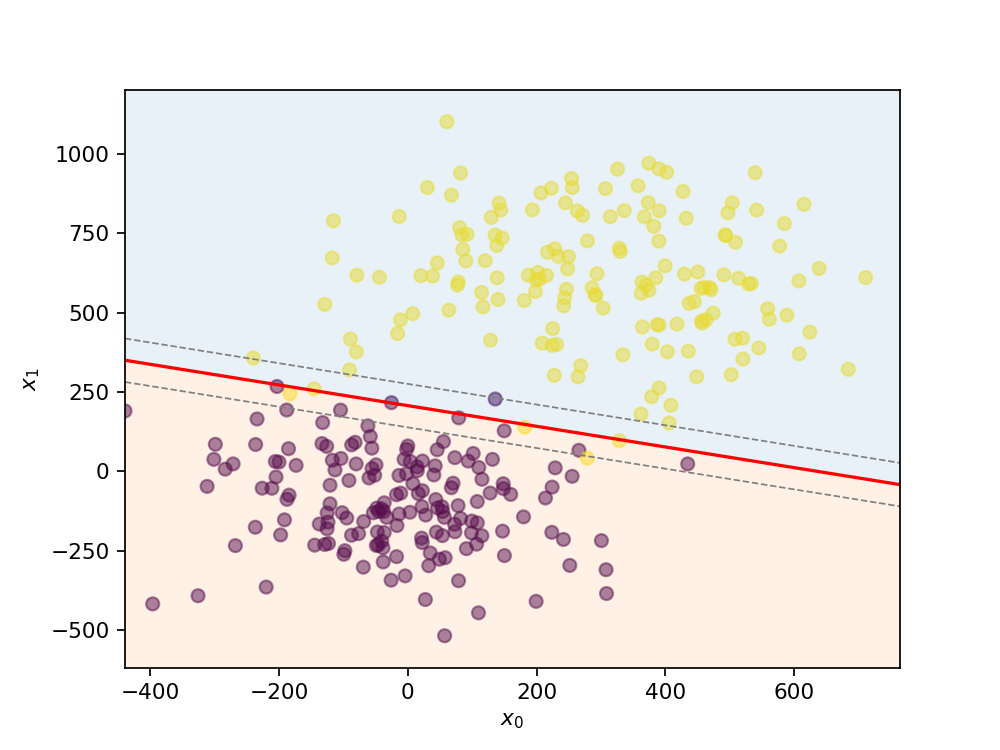

(-617.3801701479384, 1201.1960570637345)

In [24]:
def line(x, w, b):
    return - (1 / w[1]) * (w[0] * x + b)

plt.figure()
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, alpha=0.5)

# Decision boundary
xs = np.linspace(np.min(X_train[:,0]),np.max(X_train[:,0]))
plt.plot(xs, line(xs, SVM_model.w, SVM_model.b), c='red')
plt.plot(xs, line(xs, SVM_model.w, SVM_model.b - 1), c='gray', lw=.8, linestyle="--") # + Class
plt.plot(xs, line(xs, SVM_model.w, SVM_model.b + 1), c='gray', lw=.8, linestyle="--") # - Class

# Coloring the regions
plt.fill_between(xs, line(xs, SVM_model.w, SVM_model.b), np.max(X_train[:,1])+1000, alpha=.1) # +1 class
plt.fill_between(xs, line(xs, SVM_model.w, SVM_model.b), np.min(X_train[:,1])-1000, alpha=.1) # -1 class

# Styling
plt.xlabel(r'$x_0$')
plt.ylabel(r'$x_1$')
plt.xlim(np.min(X_train[:,0]),np.max(X_train[:,0])-200)
plt.ylim(np.min(X_train[:,1])-100, np.max(X_train[:,1])+100)
#plt.axis('off')

#plt.savefig("SVM.png", bbox_inches='tight', pad_inches=0)

### Making the hyperparameter C smaller gives us a wider margin 